In [423]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import scipy

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# The Data
The data consists of cancer signal magnitudes at 52 genomic locations for 64 patients.  
Patients 34-45 are afflicted with disease A.  
Patients 55-62 are afflicted with disease B.  

**Goal:** The goal of this project is to find genomic locations, such that when the signals are summed up, result in patients 34-45 ranked within the top 12, followed by patients 55-62 in the top 20, followed by the rest of the patients.

The default score is the result from summing all the locations and ranking the patients based on this. Your performance will be measured by how much you beat this method in rankings. The more packed you can get the disease patients into the higher rankings, the better. It is better to have 10 of the dieased patients within the top 12 than to have the 12 disease patients spread out over the top 20.  

Some locations probably don't progress you towards your goal in any way. If this is the case, you can always remove them.  
Trying out every possible location and checking for the best rankings will provide you the best solution, but it isn't viable because the time complexity is 2^n. On larger datasets, this would be impossible to calculate.  

**Output:**
1. A set of locations you found that achieved the best ranking
2. The ranking of all patients based on this set of locations
3. A detailed description on how you reached your results  

**Note:**  If you have multiple methods or rankings you discovered, then feel free to list them all. If you also attempted a method but found that it did not achieve what you wanted, you should include this as well. This will only help your score and won't negatively affect it in any.  

In [439]:
raw = pd.read_excel('QGtest.xlsx', index_col=0, header=None).T

In [459]:
df = raw.reset_index().drop(columns='index').rename(index=str, columns={'Locations':'Patient'})
df['Disease'] = 'N' #N for negative to disease A and B
df['Disease'][34:46] = 'A'
df['Disease'][55:63] = 'B'
df

,Patient,Location 0,Location 1,Location 2,Location 3,Location 4,Location 5,Location 6,Location 7,Location 8,...,Location 44,Location 45,Location 46,Location 47,Location 48,Location 49,Location 50,Location 51,Location 52,Disease
0,Patient 0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,0,N
1,Patient 1,0,0,0,0,1,1,0,1,0,...,2,0,2,0,2,1,0,0,0,N
2,Patient 2,0,1,1,0,0,0,1,0,0,...,0,0,2,1,0,0,0,1,0,N
3,Patient 3,0,0,0,0,0,0,0,0,0,...,0,0,2,1,2,2,0,0,0,N
4,Patient 4,0,0,0,0,0,0,0,0,0,...,2,0,2,1,0,1,1,1,1,N
5,Patient 5,0,0,0,0,0,3,1,0,0,...,2,5,2,0,6,4,0,1,0,N
6,Patient 6,0,0,1,0,0,0,1,0,1,...,0,3,0,0,0,1,0,0,0,N
7,Patient 7,0,1,0,0,0,0,2,0,0,...,2,0,0,0,1,1,0,1,1,N
8,Patient 8,0,0,0,0,0,3,0,0,0,...,0,0,1,1,2,1,0,0,0,N
9,Patient 9,0,1,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,0,N


In [460]:
#Change data type from str to numeric
numericcolumns = list(df.columns)
numericcolumns.remove('Patient')
numericcolumns.remove('Disease')
df[numericcolumns] = df[numericcolumns].apply(pd.to_numeric)

### Plotting Mean Signals
I want to plot the mean signals for all patients to get an idea of how signals at each location correlates with disease A or B. Disease A is represented in red, B in blue, and Negative for both diseases in black.

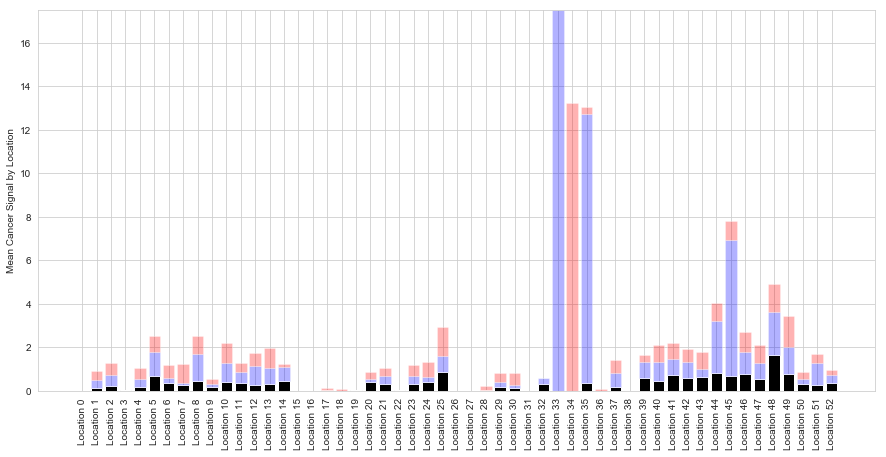

In [461]:
#Average signals for each group
Meansignals = df.groupby('Disease', as_index=False).agg(np.mean)
#Plot of the mean signal of each location for Disease A, B and No disease.
Alabels = list(Meansignals[Meansignals.Disease=='A'].columns[1:])
Avalues = Meansignals[Meansignals.Disease=='A'].iloc[0,1:]
Blabels = list(Meansignals[Meansignals.Disease=='B'].columns[1:])
Bvalues = Meansignals[Meansignals.Disease=='B'].iloc[0,1:]
Nlabels = list(Meansignals[Meansignals.Disease=='N'].columns[1:])
Nvalues = Meansignals[Meansignals.Disease=='N'].iloc[0,1:]
#Stacked plot of Location signals
plt.figure(figsize=(15,7))
plt.bar(x=Nlabels, height=Nvalues, color='k')
plt.bar(x=Blabels, height=Bvalues, bottom=Nvalues, color='b', alpha=.3)
plt.bar(x=Alabels, height=Avalues, bottom=Bvalues+Nvalues, color='r', alpha=.3)
plt.xticks(rotation=90)
plt.ylabel('Mean Cancer Signal by Location')
plt.show()

##### Removing Redundant Locations
I notice some locations have no signals for any of the three groups we are looking at. These locations are unhelpful in seperating the three classes as they will not contribute to the sum rankings. Below, I remove these signals to decrease the feature space.

In [473]:
#Remove locations that have 0 cancer signals for all patients.
SignallessLocations = ['Location 0', 'Location 15', 'Location 16', 
                     'Location 26', 'Location 27', 'Location 31', 'Location 38']
for column in numericcolumns:
    if column in SignallessLocations:
        numericcolumns.remove(column)

##### Correlation Map
The human genome consists of relationships and interactions between genes at different locations. I am curious to see if there will be any correlations between signal magnitudes at multiple locations.

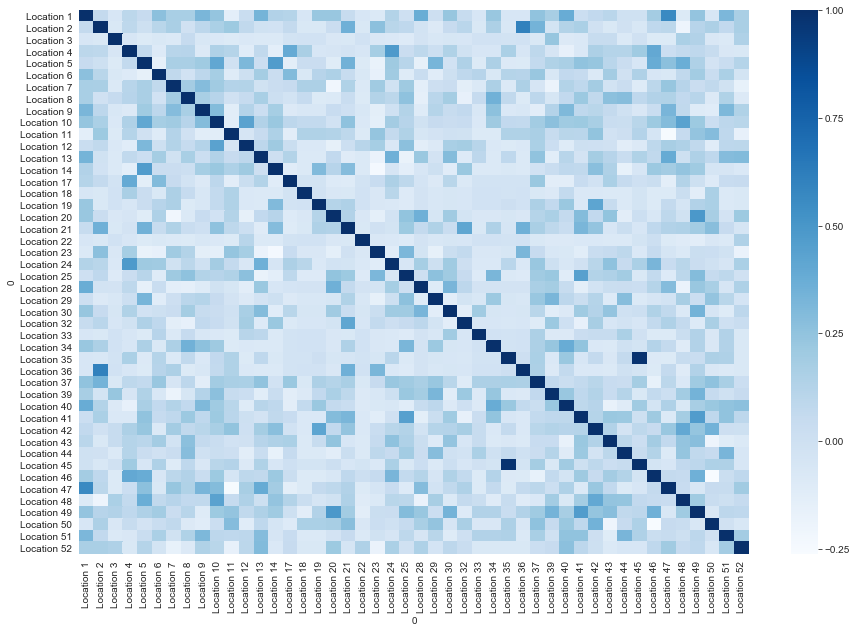

In [476]:
#Correlation table of each location.
plt.figure(figsize=(15,10))
sns.heatmap(df[numericcolumns].corr(), cmap='Blues')
plt.show()

##### Combining Classes A and B
The instructions say that disease A and B are similar. As an initial approach, I want to combine diseases A and B in order to see if patients who are negative are easier to seperate out. The weights will also be more descriptive in a binary example.

In [477]:
#Create 2 classes, 1 representing those who are Negative and 1 for patients who have disease A or B
def PosNeg(x):
    if x=='N':
        return 'N'
    else:
        return 'P'
df['hasDisease'] = df['Disease'].apply(lambda x: PosNeg(x))

In [478]:
scaler = StandardScaler()
ScaledSignals = scaler.fit_transform(df[numericcolumns])

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [479]:
#Because disease A and B are similar, I'm going to try to use 2 classes: (P)ositive or (N)egative for disease.
X = ScaledSignals
Y = df['hasDisease']

logmodel1 = LogisticRegression(penalty = 'l2', C=10, fit_intercept=True, solver='lbfgs')
logmodel1.fit(X, Y)
prediction = logmodel1.predict(X)
print('\nClassification Report\n\n', classification_report(Y, prediction))
print(cross_val_score(logmodel1,X, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           N       1.00      1.00      1.00        44
           P       1.00      1.00      1.00        20

   micro avg       1.00      1.00      1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

[0.69230769 0.69230769 0.76923077 0.76923077 0.66666667]


##### Analysis of Feature Weights
The main challenge that persists through this project is the incredibly small sample size and relatively large number of features that often contribute to multiple classes. However, we can use the weights of the logistic regression model to explain which features contributed the most to each class.

In [467]:
#Feature importances and their corresponding weights in descending order. Positive weights correlate to P class.
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)

,Locations,weights
26,Location 29,2.624503
1,Location 2,2.104397
11,Location 12,1.911980
12,Location 13,1.770803
3,Location 4,1.533271
46,Location 51,1.400400
35,Location 40,1.347249
0,Location 1,1.281808
27,Location 30,1.173720
16,Location 18,0.985812


##### Create DataFrame of Signal Sums
Here I want to create a dataframe consisting of the ranked signal sums for locations that have positive weights (weights that contributed greatly to the Positive class. I'm still working on how I want to resolve ties.

In [472]:
#I tried different slices of weights starting from the most positive weight.
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][0:f].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()

,index,Patient,Disease,SignalSum
0,57,Patient 57,B,151
1,62,Patient 62,B,142
2,59,Patient 59,B,26
3,36,Patient 36,A,20
4,55,Patient 55,B,19
5,34,Patient 34,A,19
6,42,Patient 42,A,18
7,5,Patient 5,N,17
8,52,Patient 52,N,17
9,44,Patient 44,A,16


##### Trial 2
Because the focus of this project is to isolate patients with disease A in the top 12 rankings, I wanted to try removing patients with disease B from the classifier. I felt that because A and B are so similar, the top rankings were split between the two.

In [480]:
#This time, I wanted to compare those with Disease A and Negative. I removed patients with disease B from this classifier.
scaler = StandardScaler()
ScaledSignals = scaler.fit_transform(df[df.Disease!='B'][numericcolumns])

X = ScaledSignals
Y = df[df.Disease!='B']['Disease']

logmodel1 = LogisticRegression(penalty = 'l2', C=1, fit_intercept=False, solver='lbfgs')
logmodel1.fit(X, Y)
prediction = logmodel1.predict(X)
print('\nClassification Report\n\n', classification_report(Y, prediction))
print(cross_val_score(logmodel1,X, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           A       1.00      0.92      0.96        12
           N       0.98      1.00      0.99        44

   micro avg       0.98      0.98      0.98        56
   macro avg       0.99      0.96      0.97        56
weighted avg       0.98      0.98      0.98        56

[0.66666667 0.5        0.63636364 0.63636364 0.6       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [481]:
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False).reset_index()

,index,Locations,weights
0,4,Location 5,0.644428
1,37,Location 44,0.602384
2,32,Location 39,0.477679
3,45,Location 52,0.456839
4,26,Location 32,0.449805
5,43,Location 50,0.441189
6,39,Location 46,0.417614
7,8,Location 9,0.306858
8,17,Location 20,0.306528
9,16,Location 19,0.244411


In [452]:
#Looking better. Disease A densely populates the top 10 ranks, but Negative patients still show up in the top 20.
#In this classifier, negative weights are correlated with Disease A.

FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)
#I tried to take different slices of location values i found that -8:end worked the best.
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][-8:].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()
#This is so far my best answer. 8 As in the top 10. The rest of the 4 are scattered.

,index,Patient,Disease,SignalSum
0,44,Patient 44,A,163
1,45,Patient 45,A,7
2,36,Patient 36,A,7
3,42,Patient 42,A,6
4,37,Patient 37,A,6
5,56,Patient 56,B,5
6,34,Patient 34,A,5
7,52,Patient 52,N,4
8,40,Patient 40,A,4
9,39,Patient 39,A,4


# Below is experimentation

In [453]:
POSlocations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][0:18].values

In [475]:
Xpos = df[df.Disease != 'B'][POSlocations]
scaler = StandardScaler()
ScaledSignals = scaler.fit_transform(Xpos)

Xpos = ScaledSignals
Y = df[df.Disease!='B']['Disease']

logmodel1 = LogisticRegression(penalty = 'l2', C=10, fit_intercept=True, solver='lbfgs')
logmodel1.fit(Xpos, Y)
prediction = logmodel1.predict(Xpos)
print('\nClassification Report\n\n', classification_report(Y, prediction))
print(cross_val_score(logmodel1,Xpos, Y,cv=5))


Classification Report

               precision    recall  f1-score   support

           A       1.00      0.58      0.74        12
           N       0.90      1.00      0.95        44

   micro avg       0.91      0.91      0.91        56
   macro avg       0.95      0.79      0.84        56
weighted avg       0.92      0.91      0.90        56

[0.66666667 0.33333333 0.36363636 0.81818182 0.8       ]


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
FeatureImportance = pd.DataFrame({'Locations':POSlocations, 'weights':logmodel1.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)
#I tried to take different slices of location values i found that -8:end worked the best.
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][-5:].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()

In [ ]:
#SVC performed worse.
svcmodel = SVC(C=1, kernel='linear')
svcmodel.fit(X,Y)
svcpredict = svcmodel.predict(X)
print('\nClassification Report\n\n', classification_report(Y, svcpredict))
print(cross_val_score(logmodel1,X, Y,cv=5))

In [ ]:
FeatureImportance = pd.DataFrame({'Locations':numericcolumns, 'weights':svcmodel.coef_[0]})
FeatureImportance.sort_values(by='weights', ascending=False)
locations = FeatureImportance.sort_values(by='weights', ascending=False)['Locations'][-9:].values
df['SignalSum'] = df[locations].sum(axis=1)
df[['Patient', 'Disease', 'SignalSum']].sort_values(by='SignalSum', ascending=False).reset_index()